# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size


## Setup environment

In [18]:
!pip install 'monai[all]'==0.8.0

  Using cached monai-0.8.0-202111251823-py3-none-any.whl (709 kB)
  Using cached gdown-4.4.0-py3-none-any.whl
  Using cached einops-0.4.1-py3-none-any.whl (28 kB)
  Using cached imagecodecs-2020.5.30-cp36-cp36m-manylinux2014_x86_64.whl (17.9 MB)
  Using cached nibabel-3.2.2-py3-none-any.whl (3.3 MB)
  Using cached lmdb-1.3.0-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (297 kB)
  Using cached scikit_image-0.17.2-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached tifffile-2020.9.3-py3-none-any.whl (148 kB)
  Using cached pytorch_ignite-0.4.6-py3-none-any.whl (232 kB)
  Using cached itk-5.2.1.post1-cp36-cp36m-manylinux2014_x86_64.whl (8.3 kB)
  Using cached cucim-22.4.0-py3-none-manylinux2014_x86_64.whl (8.5 MB)
  Using cached openslide_python-1.1.2-cp36-cp36m-linux_x86_64.whl
  Using cached transformers-4.18.0-py3-none-any.whl (4.0 MB)
  Using cached tensorboardX-2.5-py2.py3-none-any.whl (125 kB)
  Using cached mlflow-1.23.1-py3-none-any.whl (15.6 MB)
  Using cached 

In [29]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [34]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
# from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from monai.data.image_reader import ImageReader, ITKReader, NibabelReader, NumpyReader, PILReader

## Setup imports

In [4]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.8.0
Numpy version: 1.17.0+intel.13
Pytorch version: 1.10.2+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.2
scikit-image version: 0.17.2
Pillow version: 8.4.0
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.1
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.23.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [8]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = os.path.join(os.getcwd(),'MONAI_Spleen' )
# print(root_dir)

/root/MONAI-MedicalImage-SageMaker/Segmentation/MONAI_Spleen


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [17]:
import sagemaker as sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
compressedfile = "s3://awsjulia-monai/Task09_Spleen.tar"
localpath = "."

In [4]:
download_s3 = sagemaker.s3.S3Downloader.download(
    s3_uri=compressedfile,
    local_path=localpath,
    sagemaker_session=sess
)

In [5]:
!tar -xf Task09_Spleen.tar

tar: ./._Task09_Spleen: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/._labelsTr: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/labelsTr: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/._imagesTr: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/imagesTr: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/._imagesTs: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/imagesTs: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/._dataset.json: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/dataset.json: Cannot change ownership to uid 501, gid 50: Operation not permitted
tar: Task09_Spleen/imagesTs/._spleen_15.nii.gz: Cannot change ownership to uid 501, gid 50: Operation not permitted


In [9]:
# import os
# resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
# md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

# compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
# data_dir = os.path.join(root_dir, "Task09_Spleen")
# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, root_dir, md5)

NameError: name 'download_and_extract' is not defined

## Set MSD Spleen dataset path

In [4]:
!pip install monai[all]==0.8.0
from monai.apps import download_and_extract
import os
import glob
data_dir="Task09_Spleen"
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [5]:
len(data_dicts)

41

In [15]:
!mkdir train/imagesTr
!mkdir train/labelsTr
import shutil
for file in train_files:
    image = file['image']
    image_dest = "train/imagesTr"
    label = file['label']
    label_dest = "train/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [13]:
!mkdir val/imagesTr
!mkdir val/labelsTr
for file in val_files:
    image = file['image']
    image_dest = "val/imagesTr"
    label = file['label']
    label_dest = "val/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [18]:
prefix="MONAI-Segmentation"
bucket = sess.default_bucket()
train_to_s3 = sess.upload_data(
    path="train",
    key_prefix=prefix+"/train",
    bucket=bucket 
)
val_to_s3 = sess.upload_data(
    path="val",
    key_prefix=prefix+"/val",
    bucket=bucket 
)

In [19]:
print(train_to_s3,"\n",val_to_s3)

s3://sagemaker-ap-southeast-1-563019623253/MONAI-Segmentation/train 
 s3://sagemaker-ap-southeast-1-563019623253/MONAI-Segmentation/val


In [13]:
! apt update
!pip install ipywidgets

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease                    
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Fetched 252 kB in 1s (183 kB/s)0m                                     
Reading package lists... Done
Building dependency tree       
Reading state information... Done
58 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [5]:
%timeit
train_to_s3="s3://sagemaker-ap-southeast-1-563019623253/MONAI-Segmentation/train"
val_to_s3="s3://sagemaker-ap-southeast-1-563019623253/MONAI-Segmentation/val"
from sagemaker import get_execution_role

role = get_execution_role()

import sagemaker as sagemaker
sess = sagemaker.Session()

from sagemaker.estimator import Estimator

import json

# JSON encode hyperparameters
def json_encode_hyperparameters(hyperparameters):
    return {str(k): json.dumps(v) for (k, v) in hyperparameters.items()}

# ecr_image = "563019623253.dkr.ecr.ap-southeast-1.amazonaws.com/563019623253.dkr.ecr.ap-southeast-1.amazonaws.com/monai:latest"
ecr_image = "563019623253.dkr.ecr.ap-southeast-1.amazonaws.com/monai-test:latest"

# data_location="s3://awsjulia-monai/Task07_Pancreas.tar"
train_files="Task09_Spleen"

hyperparameters = json_encode_hyperparameters({"epochs": 10, "train_batch_size": 4, "val_batch_size": 2, "val_interval": 4, "num_workers": 1})

instance_type = "ml.p3.2xlarge"
# instance_type = "ml.p3.2xlarge"

estimator = Estimator(
    role=role,
    train_instance_count=1,
    train_instance_type=instance_type,
    image_uri=ecr_image,
    hyperparameters=hyperparameters,
#     train_instance_type="local",
)

estimator.fit({"training": train_to_s3, 
               "validation": val_to_s3})

predictor = estimator.deploy(1, instance_type)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-04-14 18:26:07 Starting - Starting the training job...
2022-04-14 18:26:33 Starting - Preparing the instances for trainingProfilerReport-1649960767: InProgress
.........
2022-04-14 18:28:07 Downloading - Downloading input data
2022-04-14 18:28:07 Training - Downloading the training image..............................
2022-04-14 18:33:08 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-14 18:33:11,349 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-14 18:33:11,377 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-14 18:33:11,386 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-14 18:33:11,471 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "ch

UnexpectedStatusException: Error for Training job monai-test-2022-04-14-18-26-07-039: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 main.py --epochs 10 --num_workers 1 --train_batch_size 4 --val_batch_size 2 --val_interval 4"
MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
Traceback (most recent call last):
  File "main.py", line 304, in <module>
    train_loader = load_data(data_files_path, train_transforms, args.train_batch_size, args.num_workers, "train")
  File "main.py", line 168, in load_data
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  File "/opt/conda/lib/python3.6/site-packages/monai/data/dataloader.py", line 84, in __init__
    super().__init__(dataset=dataset, num_workers=num_workers, **kwargs)  # type: ignore[call-ove

## Set deterministic training for reproducibility

In [10]:
# from monai.utils import first, set_determinism
# set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [30]:
# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
#         # user can also add other random transforms
#         # RandAffined(
#         #     keys=['image', 'label'],
#         #     mode=('bilinear', 'nearest'),
#         #     prob=1.0, spatial_size=(96, 96, 96),
#         #     rotate_range=(0, 0, np.pi/15),
#         #     scale_range=(0.1, 0.1, 0.1)),
#         EnsureTyped(keys=["image", "label"]),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         EnsureTyped(keys=["image", "label"]),
#     ]
# )

## Check transforms in DataLoader

In [ ]:
# import numpy as np
# import torch

# from monai.config import DtypeLike, PathLike
# from monai.data.image_reader import ImageReader, ITKReader, NibabelReader, NumpyReader, PILReader
# from monai.data.nifti_saver import NiftiSaver
# # from monai.utils import InterpolateMode, OptionalImportError, ensure_tuple, look_up_option, optional_import
# from monai.utils import optional_import

# nib, _ = optional_import("nibabel")
# Image, _ = optional_import("PIL.Image")

# __all__ = ["LoadImage", "SaveImage", "SUPPORTED_READERS"]

# SUPPORTED_READERS = {
#     "itkreader": ITKReader,
#     "numpyreader": NumpyReader,
#     "pilreader": PILReader,
#     "nibabelreader": NibabelReader,
# }

# check_ds = Dataset(data=val_files, transform=val_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # plot the slice [:, :, 80]
# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(image[:, :, 80], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 80])
# plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [13]:
# train_ds = CacheDataset(
#     data=train_files, transform=train_transforms,
#     cache_rate=1.0, num_workers=4)
# # train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# # use batch_size=2 to load images and use RandCropByPosNegLabeld
# # to generate 2 x 4 images for network training
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# val_ds = CacheDataset(
#     data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# # val_ds = Dataset(data=val_files, transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


## Create Model, Loss, Optimizer

In [15]:
# # standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
# device = torch.device("cuda:0")
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [17]:
# %%time
# max_epochs = 50 #600
# val_interval = 2
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
# post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
# post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

# for epoch in range(max_epochs):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{max_epochs}")
#     model.train()
#     epoch_loss = 0
#     step = 0
#     for batch_data in train_loader:
#         step += 1
#         inputs, labels = (
#             batch_data["image"].to(device),
#             batch_data["label"].to(device),
#         )
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         print(
#             f"{step}/{len(train_ds) // train_loader.batch_size}, "
#             f"train_loss: {loss.item():.4f}")
#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         with torch.no_grad():
#             for val_data in val_loader:
#                 val_inputs, val_labels = (
#                     val_data["image"].to(device),
#                     val_data["label"].to(device),
#                 )
#                 roi_size = (160, 160, 160)
#                 sw_batch_size = 4
#                 val_outputs = sliding_window_inference(
#                     val_inputs, roi_size, sw_batch_size, model)
#                 val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#                 val_labels = [post_label(i) for i in decollate_batch(val_labels)]
#                 # compute metric for current iteration
#                 dice_metric(y_pred=val_outputs, y=val_labels)

#             # aggregate the final mean dice result
#             metric = dice_metric.aggregate().item()
#             # reset the status for next validation round
#             dice_metric.reset()

#             metric_values.append(metric)
#             if metric > best_metric:
#                 best_metric = metric
#                 best_metric_epoch = epoch + 1
#                 torch.save(model.state_dict(), os.path.join(
#                     root_dir, "best_metric_model.pth"))
#                 print("saved new best metric model")
#             print(
#                 f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
#                 f"\nbest mean dice: {best_metric:.4f} "
#                 f"at epoch: {best_metric_epoch}"
#             )

----------
epoch 1/50
1/16, train_loss: 0.2984
2/16, train_loss: 0.2804
3/16, train_loss: 0.2478
4/16, train_loss: 0.2837
5/16, train_loss: 0.2852
6/16, train_loss: 0.3782
7/16, train_loss: 0.3060
8/16, train_loss: 0.2568
9/16, train_loss: 0.1768
10/16, train_loss: 0.3218
11/16, train_loss: 0.2627
12/16, train_loss: 0.3190
13/16, train_loss: 0.2725
14/16, train_loss: 0.2711
15/16, train_loss: 0.2984
16/16, train_loss: 0.2636
epoch 1 average loss: 0.2827
----------
epoch 2/50
1/16, train_loss: 0.2521
2/16, train_loss: 0.3939
3/16, train_loss: 0.2991
4/16, train_loss: 0.3539
5/16, train_loss: 0.3410
6/16, train_loss: 0.2288
7/16, train_loss: 0.1931
8/16, train_loss: 0.3333
9/16, train_loss: 0.2588
10/16, train_loss: 0.2221
11/16, train_loss: 0.2894
12/16, train_loss: 0.3605
13/16, train_loss: 0.2945
14/16, train_loss: 0.2844
15/16, train_loss: 0.3344
16/16, train_loss: 0.2304
epoch 2 average loss: 0.2919
saved new best metric model
current epoch: 2 current mean dice: 0.0690
best mean dic

In [18]:
# print(
#     f"train completed, best_metric: {best_metric:.4f} "
#     f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.3874 at epoch: 38


## Plot the loss and metric

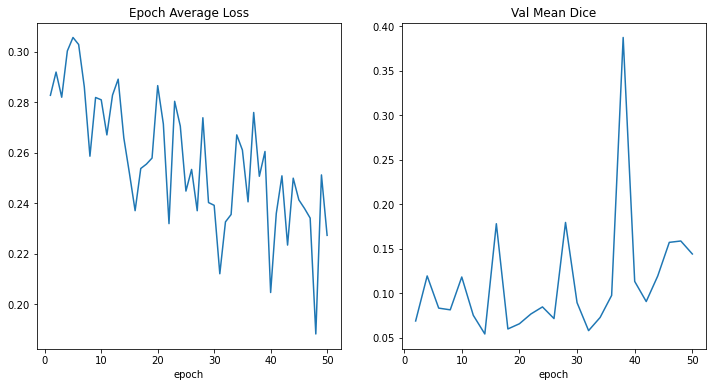

In [20]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

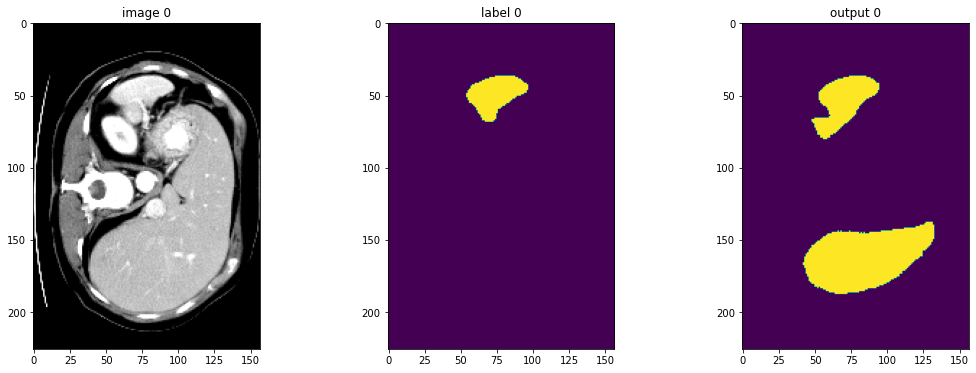

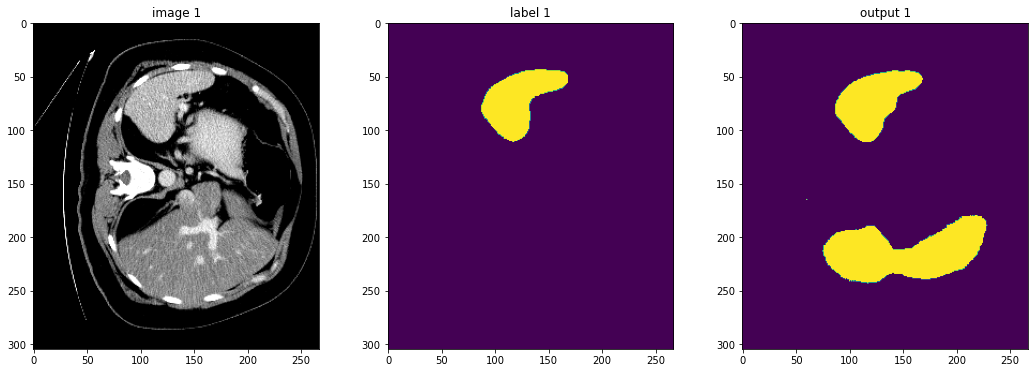

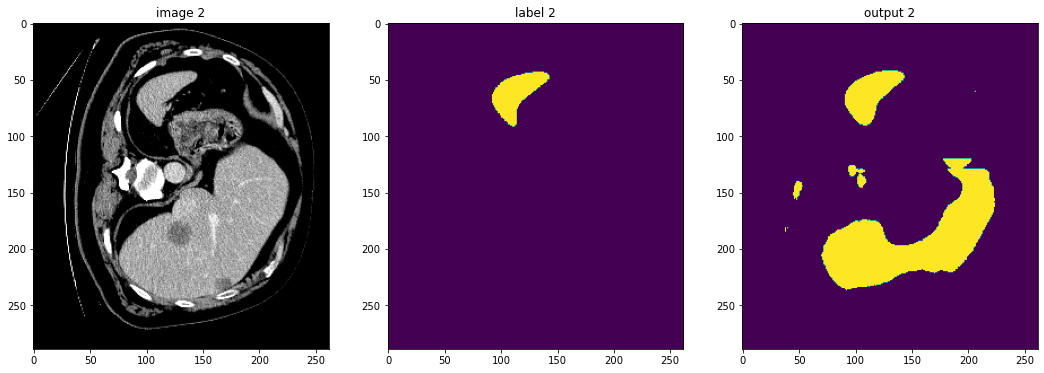

In [21]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [22]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [16]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.9637420177459717


## Inference on Test Set

In [23]:
test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [24]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_1/spleen_1_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_11/spleen_11_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_15/spleen_15_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_23/spleen_23_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_30/spleen_30_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_34/spleen_34_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_35/spleen_35_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_36/spleen_36_seg.nii.gz.
file written: /home/ec2-user/SageMaker/segmentation/tutorials/3d_segmentation/out/spleen_3

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)